This model uses as features: 
* Customer demographics removing Comuna and Profesion, (customer_feat)
* Old count history, previous 13 th month (old_history_feat) 
* Last 13 months count history (current_history_feat)
* This model balanced classes using the is_balanced parameter of lightgbm

# Notebook Setup

In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
!pip install ml-metrics
!pip install shap

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
cd /content/drive/MyDrive/itau/

/content/drive/MyDrive/itau


# Preparing Data

In [80]:
import pandas as pd
import numpy as np
from dataset.dataset import Dataset

In [81]:
ds = Dataset()
ds.load_data()

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [91]:
def get_features(train=True):
    counts = ds.get_transactions_counts()
    # Customer features
    customer_cols = ['Edad', 'Renta', 'Meses_antiguedad', 'Ciudad','Estado_civil', 'Principalidad']
    customer_feat = ds.customers_df.set_index("id")[customer_cols]
    customer_feat = (customer_feat.astype({'Principalidad':'object', 'Ciudad':'object'})
        .fillna({'Principalidad':'Missing', 'Ciudad':'Missing'})
        .astype({'Principalidad':'category', 'Ciudad':'category'}))
    customer_feat.rename(columns=lambda x: f"customer_{x}", inplace=True)
    # Transactions features
    input_counts = counts.iloc[:,:-3].copy() if train else counts.copy() #-3 is because these are in the training features
    old_history_feat = pd.DataFrame((input_counts.iloc[:,:-12].sum(axis=1)>0).astype('float'),columns=['old_count']).unstack().fillna(0)
    old_history_feat.columns = ["_".join(col) for col in old_history_feat.columns]
    current_history_feat = input_counts.iloc[:,-12:].unstack().fillna(0)
    current_history_feat.columns = ["_".join(np.array(col,dtype=str)) for col in current_history_feat.columns]
    # Trim transactions 
    last_year = input_counts.iloc[:,-12:].fillna(0).transpose()
    trim_history_feat = last_year.groupby(np.arange(0,last_year.shape[0])//3).sum().transpose() > 0
    trim_history_feat = trim_history_feat.astype(int)
    trim_starts = last_year.index.droplevel(0)[np.arange(0,last_year.shape[0])%3==0].astype(str)
    trim_ends = last_year.index.droplevel(0)[np.arange(0,last_year.shape[0])%3==2].astype(str)
    trim_history_feat.columns = 'Q_cnt_' + trim_starts + '_' + trim_ends
    trim_history_feat = trim_history_feat.unstack()
    trim_history_feat.columns = ["_".join(np.array(col,dtype=str)) for col in trim_history_feat.columns]
    # Campain features
    campains_df = pd.concat([ds.campains_test_df, ds.campains_train_df.drop(columns=['Resultado'])],axis=0)
    end = 202007 if train else 202010
    mask_date = (campains_df["Periodo"] > end - 3) & (campains_df["Periodo"] <= end)
    mask_duration = campains_df["Duracion_Campaña"] <= 2
    mask = mask_date & mask_duration
    campains_feat = (campains_df[mask].groupby(['id','Producto-Tipo'])
                    .agg({'Periodo':'count'}).rename(columns={'Periodo':'campain_count'})
                    .unstack())
    campains_feat.columns = ["_".join(np.array(col,dtype=str)) for col in campains_feat.columns]
    # Full features
    features = pd.concat([trim_history_feat, customer_feat, old_history_feat, current_history_feat], axis=1)
    features = features.merge(campains_feat, on='id',how='left').fillna({'campain_count_A-A':0, 'campain_count_B-B':0, 'campain_count_C-D':0, 'campain_count_D-E':0, 'campain_count_E-E':0})
    features["customer_Ciudad"] = ("C_"+features["customer_Ciudad"].astype(str)).astype("category")
    features.rename(columns={"customer_Ciudad":"customer_City"})
    return features

In [92]:
# Features
train_features = get_features(train=True)
test_features = get_features(train=False)
# Labels
labels = (ds.get_transactions_counts().iloc[:,-3:].sum(axis=1))
labels = labels.unstack(-1) > 0
actuals = [list(np.array(labels.columns)[x]) for x in labels.values]
labels = labels.astype(int)

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, labels, random_state=42)

In [85]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score

In [86]:
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

In [87]:
 class Ranker:
    def __init__(self, probs):
        self.probs = np.array(probs)
        self.probs = self.probs.round(2)
        self.probs.sort()

    def rank_prob_empirical(self, prob):
        self.probs__ = np.array(self.probs).reshape(-1)
        n = len(self.probs__)
        result = interpolate(self.probs__, np.arange(1, n+1) / n, prob)
        return np.array(result)

In [88]:
from tqdm import tqdm

def interpolate(x, y, ts):
    """
    x: x values for certainty values
    t: point to interpolate certainty
    """
    ys = []
    with tqdm(total=len(ts)) as pbar:
        for i, t in enumerate(ts):
            y_ = y[0] if t <= x[0] else y[-1]
            for i in range(len(x)-1):
                if (t >= x[i]) & (t<=x[i+1]):
                    alpha = (x[i+1] - t)/(x[i+1] - x[i])
                    y_ = (alpha) * y[i] + (1-alpha) * y[i+1]
                    break
            ys.append(y_)
            pbar.update(1)
    ys = np.array(ys)
    return ys

In [89]:
from sklearn.neighbors import KernelDensity
import scipy.integrate as integrate

def certainty(a, b):
    eps = 1e-7
    pb = b[0]/(b[0]+a[0]+eps)
    pa = a[0]/(b[0]+a[0]+eps)
    x = 0.5*a[1][1:]+0.5*a[1][:-1]
    H = -(pb*np.log(pb+eps) + pa*np.log(pa + eps))
    C = 1 - H
    return x, C

# Random Forest

ValueError: ignored

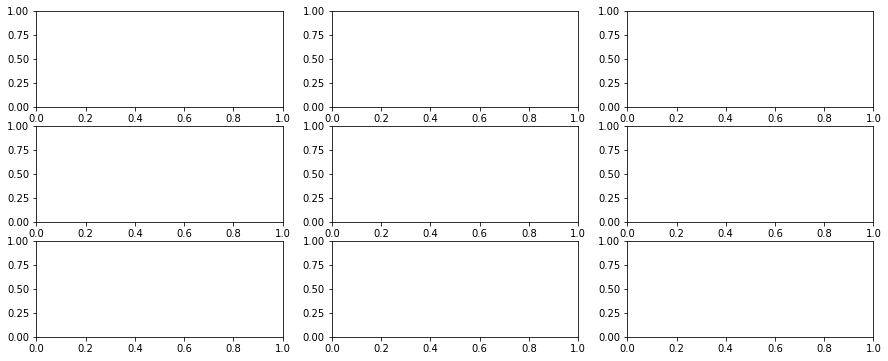

In [45]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
encoder = OrdinalEncoder()
encoder.fit(train_features.loc[:,train_features.dtypes=='category'].iloc[:].astype(str))
X_train_num = X_train.copy()
X_test_num = X_test.copy()
X_train_num.loc[:,X_train.dtypes=='category'] = encoder.transform(X_train.loc[:,X_train.dtypes=='category'].astype(str))
X_test_num.loc[:,X_test.dtypes=='category'] = encoder.transform(X_test.loc[:,X_train.dtypes=='category'].astype(str))

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
models = []
certainties = []
rankers = []
def plotting(counters, ax):
    for i, prod_index in enumerate(counters):
        #model = LGBMClassifier(is_unbalance=False).fit(X_train, y_train.iloc[:,prod_index])
        model = RandomForestClassifier().fit(X_train_num, y_train.iloc[:,prod_index])
        models.append(model)
        # Plotting 
        clf = model
        plt.sca(ax[0][i])
        plt.title(f'{ds.PRODUCTS[prod_index]}')
        #a = plt.hist(clf.predict_proba(X_test)[(y_test.iloc[:,prod_index]==1).values,1], bins=40, density=True)
        a = plt.hist(clf.predict_proba(X_test_num)[(y_test.iloc[:,prod_index]==1).values,1], bins=40, density=True)
        plt.sca(ax[1][i])
        #b = plt.hist(clf.predict_proba(X_test)[(y_test.iloc[:,prod_index]==0).values,1], color='orange', bins=40, density=True)
        b = plt.hist(clf.predict_proba(X_test_num)[(y_test.iloc[:,prod_index]==0).values,1], color='orange', bins=40, density=True)
        plt.sca(ax[2][i])
        x, C = certainty(a, b)
        certainties.append((x,C))
        #test_neg_preds = clf.predict_proba(X_test)[(y_test.iloc[:,prod_index]==0).values,1]
        test_neg_preds = clf.predict_proba(X_test_num)[(y_test.iloc[:,prod_index]==0).values,1]
        rankers.append(Ranker(test_neg_preds))
        plt.plot(x, C, '-*')
f, ax = plt.subplots(3,3,figsize=(15,6))
plotting([0,1,2],ax)
f, ax = plt.subplots(3,2,figsize=(10,6))
plotting([3,4],ax)
plt.show()

# LGBM

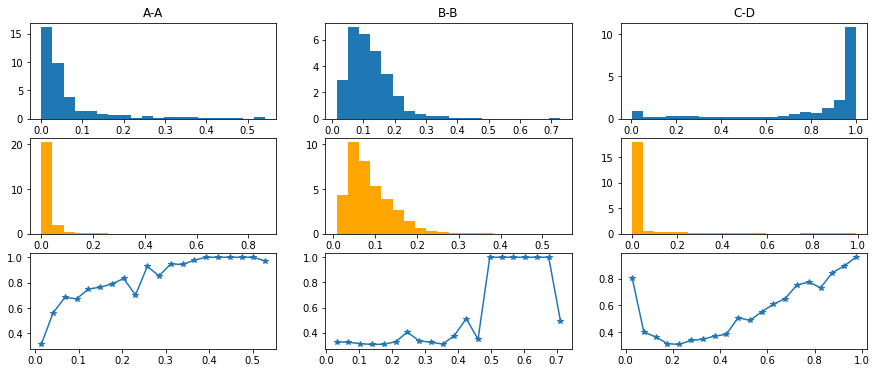

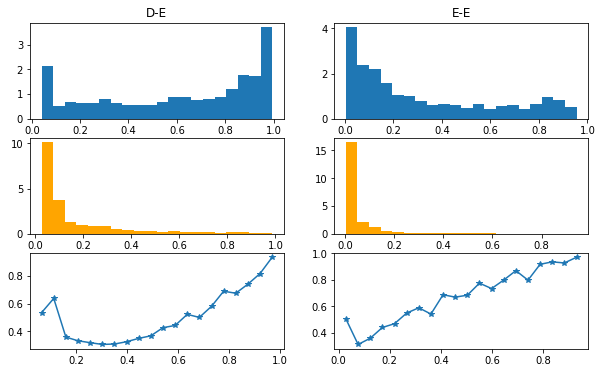

In [94]:
models = []
certainties = []
rankers = []
def plotting(counters, ax):
    for i, prod_index in enumerate(counters):
        model = LGBMClassifier(is_unbalance=False).fit(X_train, y_train.iloc[:,prod_index])
        models.append(model)
        # Plotting 
        clf = model
        plt.sca(ax[0][i])
        plt.title(f'{ds.PRODUCTS[prod_index]}')
        a = plt.hist(clf.predict_proba(X_test)[(y_test.iloc[:,prod_index]==1).values,1], bins=20, density=True)
        plt.sca(ax[1][i])
        b = plt.hist(clf.predict_proba(X_test)[(y_test.iloc[:,prod_index]==0).values,1], color='orange', bins=20, density=True)
        plt.sca(ax[2][i])
        x, C = certainty(a, b)
        certainties.append((x,C))
        test_neg_preds = clf.predict_proba(X_test)[(y_test.iloc[:,prod_index]==0).values,1]
        rankers.append(Ranker(test_neg_preds))
        plt.plot(x, C, '-*')
        
f, ax = plt.subplots(3,3,figsize=(15,6))
plotting([0,1,2],ax)
f, ax = plt.subplots(3,2,figsize=(10,6))
plotting([3,4],ax)
plt.show()

In [70]:
def rank_score(prob, certainty, w1=1, e1=1, w2=0, e2=0, w3=0, e3=0):
    rank_score = w1 * prob * (certainty ** e1) + w2 * prob * (1-certainty**e2) + w3 * (1-prob) * (1-certainty**e3)
    return rank_score
rank_score(np.array([0.8,0,0.6,1]), np.array([0.6,0.1,1,0.4]))

array([0.48, 0.  , 0.6 , 0.4 ])

100%|██████████| 99/99 [00:00<00:00, 60840.45it/s]


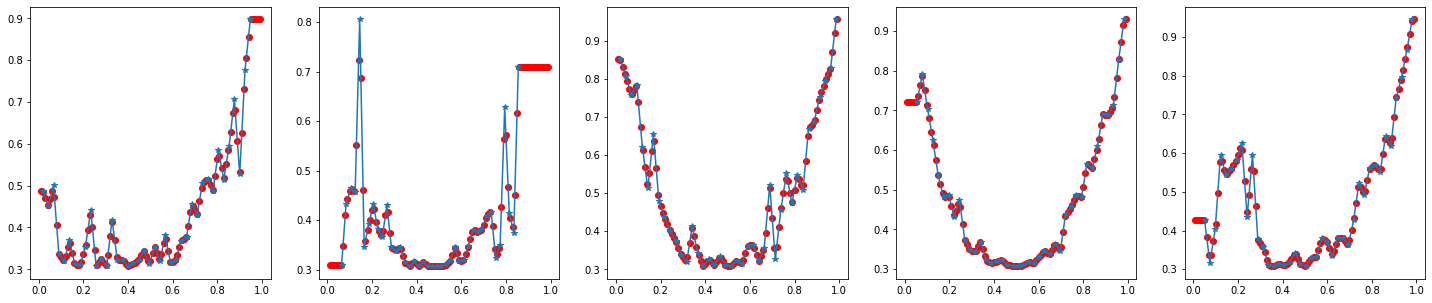

In [ ]:
f, ax = plt.subplots(1,5,figsize=(25,5))
for i,ax in enumerate(ax):
    x, certainty = certainties[i]
    ts = np.arange(0.01,1,0.01)
    ys = interpolate(x, certainty, ts=ts)
    plt.sca(ax)
    plt.plot(ts,ys,'ro')
    plt.plot(x,certainty,'*-')

## Inference

In [ ]:
eps = 1e-7
models = []

for prod_index in range(5):
    lgbm_unb = LGBMClassifier(is_unbalance=False).fit(train_features, labels.iloc[:,prod_index])
    models.append(lgbm_unb)

In [ ]:
#rank_scores = []
#rank_scores_ = []
preds = []
for i, model in enumerate(models):
    pred = model.predict_proba(test_features)[:,1]
    x, certainty = certainties[i]

    certs = interpolate(x, certainty, ts=pred)
    #prob_ranks = rankers[i].rank_prob_empirical(pred)
    #rank_scores.append(prob_ranks)
    preds.append(pred)
    #rank_scores_.append(rank_score(rank_scores[:,i], certs))
#rank_scores_ = np.array(rank_scores_).transpose()
preds = np.array(preds).transpose()

100%|██████████| 79539/79539 [00:01<00:00, 69760.61it/s]


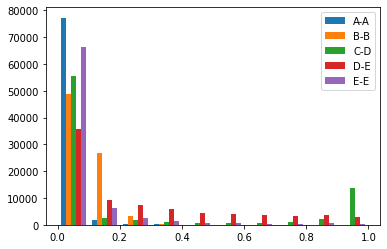

In [ ]:
plt.hist(preds);
plt.legend(ds.PRODUCTS)

In [ ]:
from utils import from_preds_to_products
product_preds = from_preds_to_products(preds)

In [ ]:
entrega_df = pd.read_csv(ds.BASE_DATA_PATH / 'ejemplo_entregaVF.csv', index_col='id')
entrega_df['productos'] = [" ".join(x) for x in product_preds]
from datetime import datetime
filename = ds.BASE_PATH/f'predictions/{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.csv'
entrega_df.to_csv(filename)


## Checking the performance

In [72]:
from lightgbm import LGBMClassifier
train_preds_ = []
test_preds_ = []
for prod_index in range(5):
    model = LGBMClassifier(is_unbalance=False).fit(X_train, y_train.iloc[:,prod_index])
    pred = model.predict_proba(X_train.iloc[:10000])[:,1]
    train_preds_.append(pred)
    pred = model.predict_proba(X_test.iloc[:10000])[:,1]
    test_preds_.append(pred)

In [73]:
from utils import mAP
train_preds = []
test_preds = []

for prod_index in range(5):
    x, certainty = certainties[prod_index]
    
    pred = train_preds_[prod_index]
    certs = interpolate(x, certainty, ts=pred)
    #train_preds.append(pred)
    train_preds.append(rank_score(pred, certs))
    #train_preds.append(rankers[prod_index].rank_prob_empirical(pred))

    pred = test_preds_[prod_index]
    certs = interpolate(x, certainty, ts=pred)
    #test_preds.append(pred)
    test_preds.append(rank_score(pred, certs))
    #test_preds.append(rankers[prod_index].rank_prob_empirical(pred))
    
train_preds = np.array(train_preds).transpose()
test_preds = np.array(test_preds).transpose()

from sklearn.model_selection import train_test_split
from utils import mAP
print(f"Max mAP: {mAP(y_true=y_train.values, y_pred=y_train.values)}")
print(f"Train mAP: {mAP(y_true=y_train.values, y_pred=train_preds)}")
print(f"Test mAP: {mAP(y_true=y_test.values, y_pred=test_preds)}")

100%|██████████| 10000/10000 [00:00<00:00, 130183.90it/s]


Max mAP: 0.5268213363730848
Train mAP: 0.47508263888888885
Test mAP: 0.46996791666666665


## Checking importances

=====A-A=====


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


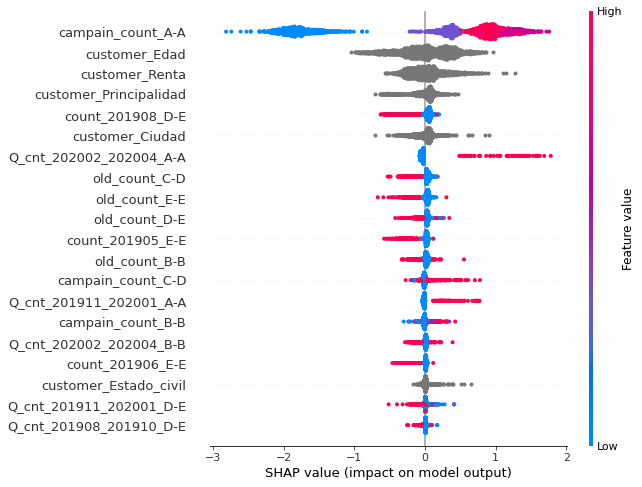

=====B-B=====


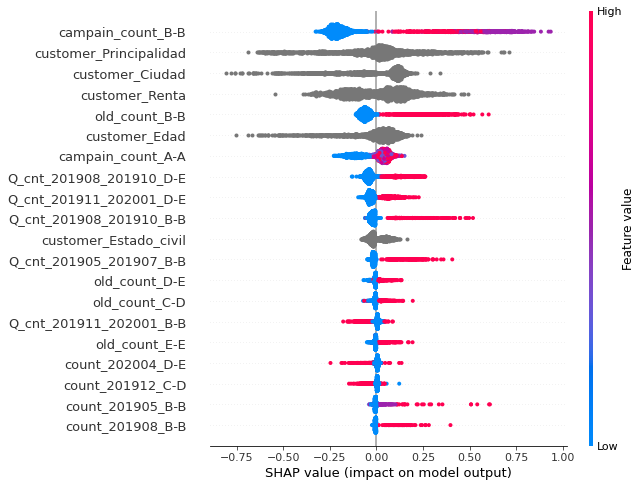

=====C-D=====


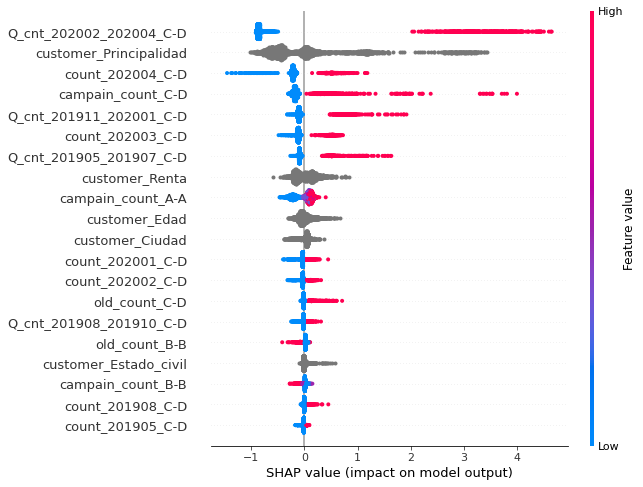

=====D-E=====


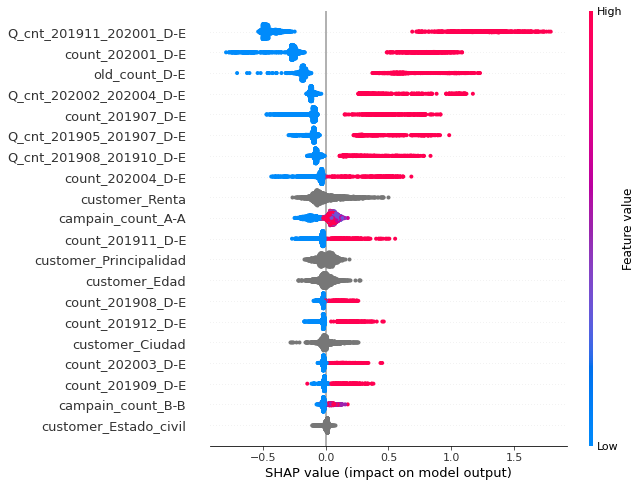

=====E-E=====


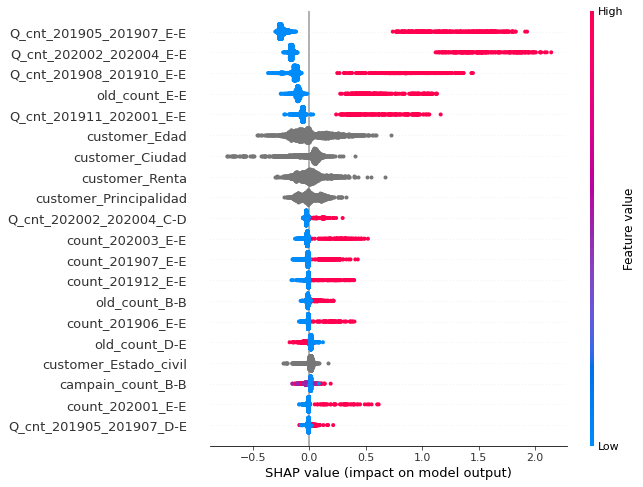

In [95]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
import shap
for i in range(5): 
    print(f"====={ds.PRODUCTS[i]}=====")
    f, ax = plt.subplots(1,1)
    plt.sca(ax)
    S = X_test.sample(2000, random_state=42)
    shap_values = shap.TreeExplainer(models[i]).shap_values(S)
    #shap.summary_plot(shap_values, X_train, plot_type="bar",plot_size=(5,5))
    shap.summary_plot(shap_values[1], S, plot_size=(8,8))

Concluions: Importances, Buying the previous quarter has a positive impact on the chances 

In [142]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
i = 3
def shap_plot(j):
    model = models[i]
    S = X_test.sample(1, random_state=42)
    explainerModel = shap.TreeExplainer(models[i])
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value[1], shap_values_Model[1], S)
    return p

a = shap_plot(0)
a

/usr/local/lib/python3.6/dist-packages/shap/explainers/_tree.py:300: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



In [ ]:
shap_plot(1)

In [ ]:
shap.summary_plot(shap_values)

In [33]:
import plotly.express as px
px.barshap_values

[array([[-2.50207296e-03, -1.16418037e-04,  8.91878410e-02, ...,
         -4.08288838e-03,  1.14545378e-01,  0.00000000e+00],
        [-2.65425542e-03, -3.01793005e-04,  8.43539902e-02, ...,
         -9.24812295e-03,  1.76673420e-01,  0.00000000e+00],
        [-2.65425542e-03, -1.63226558e-04,  7.85773862e-02, ...,
         -8.89734338e-03,  1.96514955e-01,  0.00000000e+00],
        ...,
        [ 1.17647468e-03,  2.56584335e-04,  9.95035150e-02, ...,
         -1.25245791e-02,  1.79012389e-01,  0.00000000e+00],
        [-2.57665373e-03, -1.45414040e-03,  1.00097473e-01, ...,
         -8.22756152e-03,  1.39851761e-01,  0.00000000e+00],
        [-2.22045929e-03,  2.97698305e-04,  7.46825107e-02, ...,
          1.77658086e-02, -2.16879390e+00,  0.00000000e+00]]),
 array([[ 2.50207296e-03,  1.16418037e-04, -8.91878410e-02, ...,
          4.08288838e-03, -1.14545378e-01,  0.00000000e+00],
        [ 2.65425542e-03,  3.01793005e-04, -8.43539902e-02, ...,
          9.24812295e-03, -1.76673420e

=====A-A=====


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


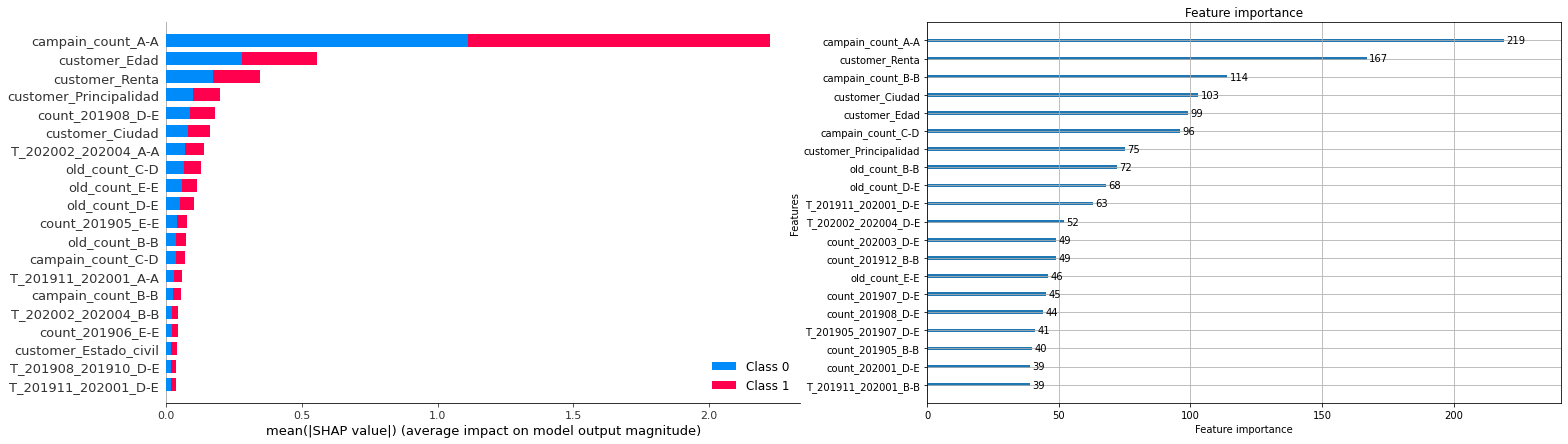

=====B-B=====


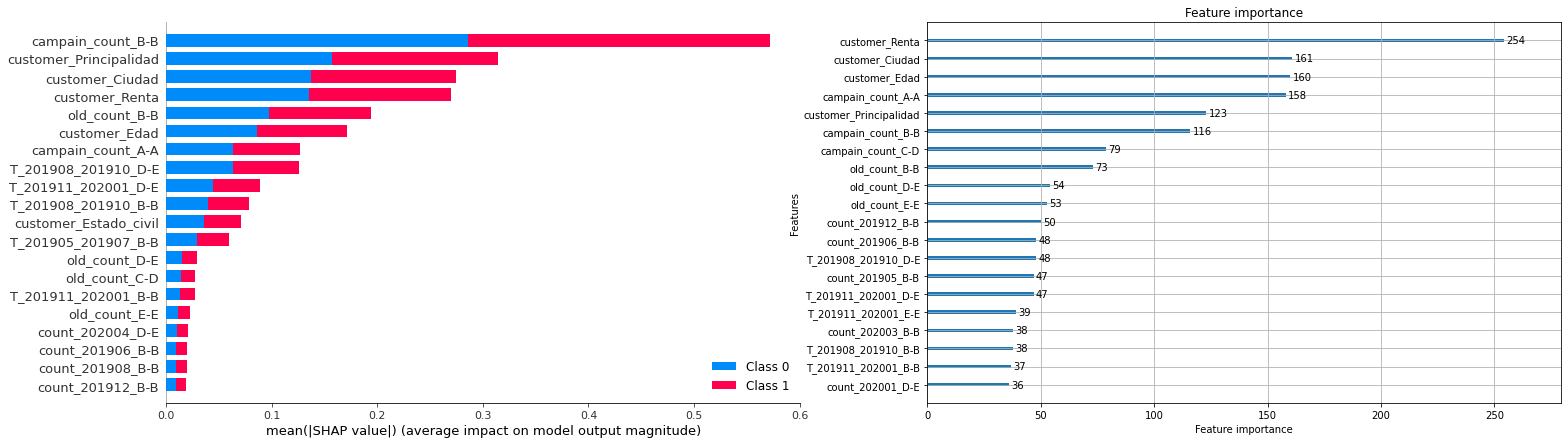

=====C-D=====


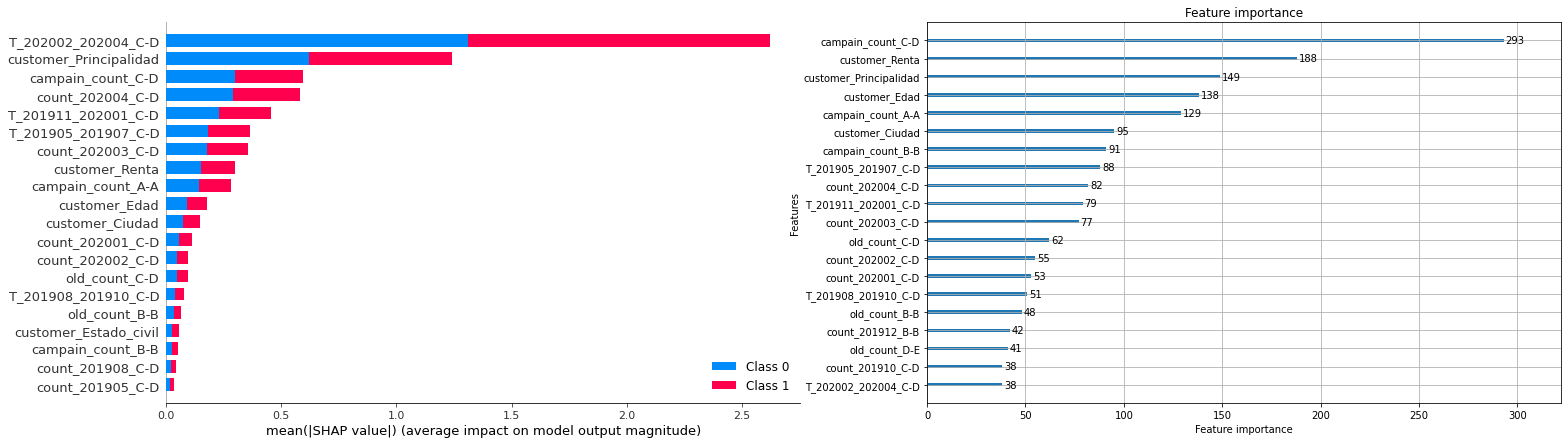

=====D-E=====


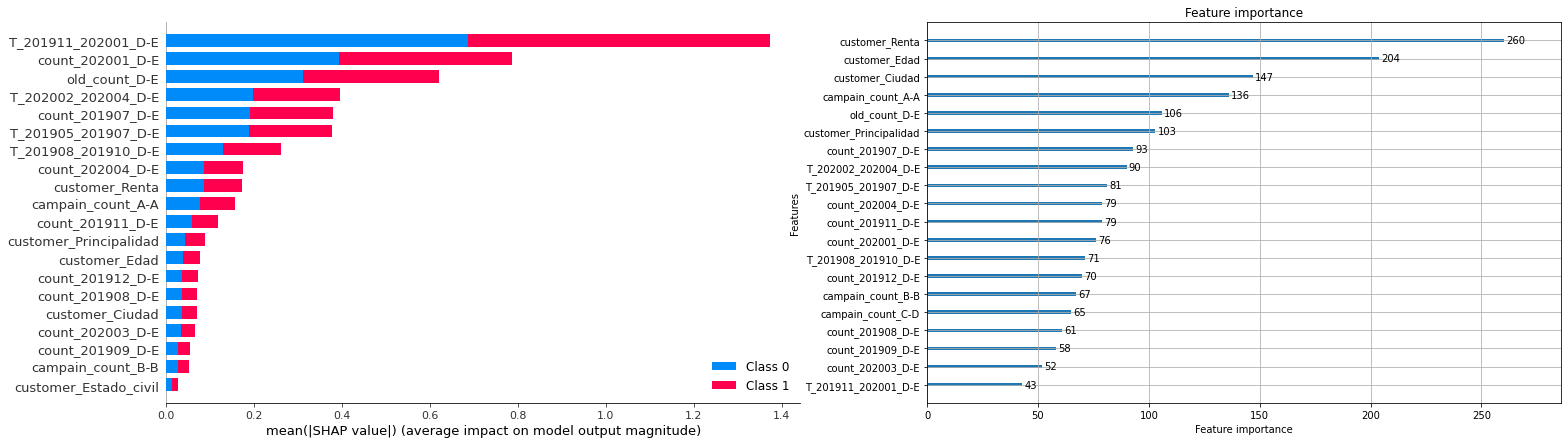

=====E-E=====


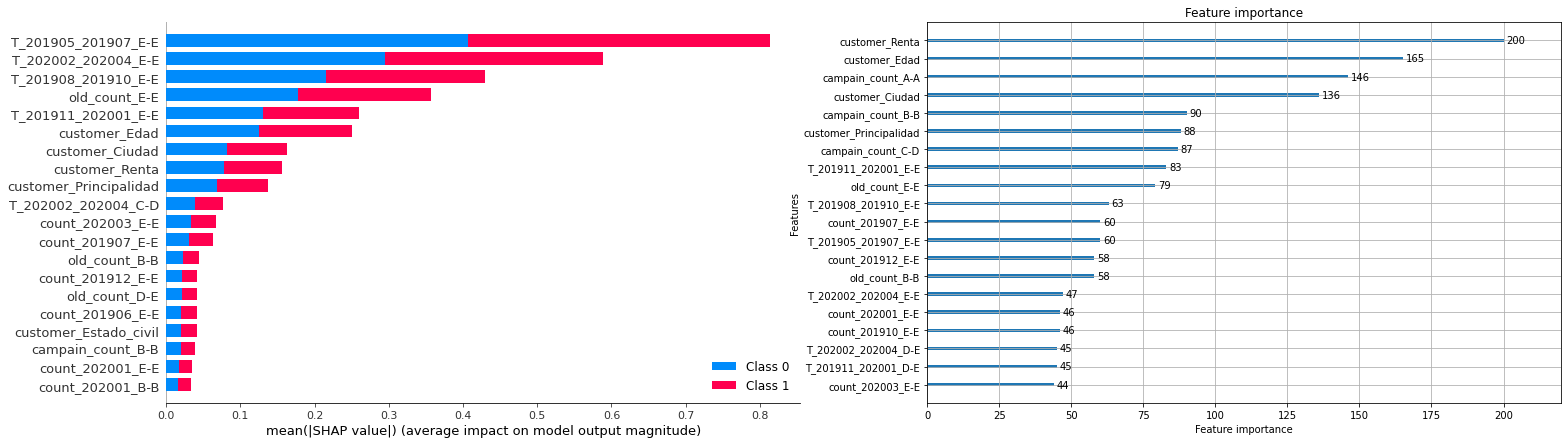

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
import shap
for i in range(5): 
    print(f"====={ds.PRODUCTS[i]}=====")
    f, ax = plt.subplots(1,2)
    plot_importance(models[i],figsize=(5,5), max_num_features=20, ax=ax[1])
    plt.sca(ax[0])
    shap_values = shap.TreeExplainer(models[i]).shap_values(X_test)
    shap.summary_plot(shap_values, X_train, plot_type="bar",plot_size=(25,7))

# Submission

In [ ]:
model = MultiOutputClassifier(LGBMClassifier())
model.set_params(**grid_search.best_params_)
model.fit(train_features, labels)

MultiOutputClassifier(estimator=LGBMClassifier(boosting_type='gbdt',
                                               class_weight=None,
                                               colsample_bytree=1.0,
                                               importance_type='split',
                                               learning_rate=0.1, max_depth=-1,
                                               min_child_samples=20,
                                               min_child_weight=0.001,
                                               min_split_gain=0.0,
                                               n_estimators=50, n_jobs=-1,
                                               num_leaves=31, objective=None,
                                               random_state=None, reg_alpha=0.0,
                                               reg_lambda=0.0, silent=True,
                                               subsample=1.0,
                                               subsample_for_bin=

In [ ]:
from utils import from_preds_to_products
preds = model.predict_proba(test_features)

In [ ]:
product_preds = from_preds_to_products(preds)

In [ ]:
entrega_df = pd.read_csv(ds.BASE_DATA_PATH / 'ejemplo_entregaVF.csv', index_col='id')
entrega_df['productos'] = [" ".join(x) for x in product_preds]
from datetime import datetime
filename = ds.BASE_PATH/f'predictions/{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.csv'
entrega_df.to_csv(filename)